In [1]:
import sys
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error
from tqdm.auto import tqdm
from typing import List
import time

sys.path.append("../")

from RGS import FastRandomizedGreedySelection, RandomizedGreedySelection
from data_generator import *
from data_plotting import *

In [ ]:
def calculate_df(y, y_true, y_pred, n, sigma):
    """Calculate degrees of freedom using the provided formula."""
    train_error = np.mean((y - y_pred)**2)
    insample_error = np.mean((y_true - y_pred)**2)
    df = n/(2*sigma**2) * (insample_error - train_error + sigma**2)
    return df

In [ ]:
def compute_penalty(m: int, omega: List[float], sigma2: float, n: int) -> float:
    """Compute the penalty term for feature selection using sorted coefficients."""
    omega_sorted = sorted(omega, reverse=True)
    return (2 * sigma2**2 / n) * sum(np.log(p / (j+1)) * omega_sorted[j] for j in range(p))

In [ ]:
def compute_penalized_score(model, X, y_true, k, sigma2, n, p):
    """
    Compute penalized score using MSE + penalty.
    
    Parameters
    ----------
    model : RGS/GS model
        Fitted model with .coef_ attribute
    X : ndarray
        Input design matrix
    y_true : ndarray
        True signal (without noise)
    k : int
        Number of features to use
    sigma2 : float
        True noise variance
    n : int
        Sample size
    p : int
        Number of features
        
    Returns
    -------
    float
        Penalized score (MSE + penalty)
    """
    # Get predictions and MSE
    y_pred = model.predict(X, k=k)
    mse = mean_squared_error(y_true, y_pred)
    
#     # Get coefficients and sort them by absolute value
#     coef = np.abs(model.coef_)  # Get absolute values
#     coef_sorted = np.sort(coef)[::-1]  # Sort in descending order
    
#     # Use top k coefficients
#     coef_k = coef_sorted[:k]
    
    # Compute penalty
    penalty = 2*sigma2**2/n*k*np.log(p/k)
    
    return mse + penalty

In [ ]:
def run_simulation(n_predictors=250, n_train=2000, signal_proportion=0.04, cov='orthogonal', n_sim=10):
    """
    Run simulation comparing different methods, varying k_max during training.
    """
    
    # Start timing
    start_time = time.time()
    
    # Generate base design matrix
    X_generators = {
        'orthogonal': generate_orthogonal_X,
        'banded': generate_banded_X
    }
    if isinstance(cov, str):
        if cov not in X_generators:
            raise ValueError(f"Unknown generator: {cov}. Available generators: {list(X_generators.keys())}")
        X_generator = X_generators[cov]
    else:
        # Assume it's a callable
        X_generator = cov
    X = X_generator(n_predictors, n_train)
    
    # Define k values for training and m values for RGS
    k_values = list(range(2, 19, 4))  # [5, 10, 15, ..., 50]
    base = 2
    num_points = 7
    m_values = [int(2 + (n_predictors-2) * (base**x - 1)/(base**(num_points-1) - 1)) 
            for x in range(num_points)]
    
    # Initialize results storage
    results = []
    
    # Define example generators with different noise levels
    sigmas = [10, 25, 35]
#     sigmas = [10, 20, 30, 35, 40, 45]
    example_generators = {
#         f'sigma_{sigmas[0]}': generate_exact_sparsity_example,
#         f'sigma_{sigmas[1]}': generate_exact_sparsity_example,
#         f'sigma_{sigmas[2]}': generate_exact_sparsity_example,
#         f'sigma_{sigmas[3]}': generate_exact_sparsity_example,
#         f'sigma_{sigmas[4]}': generate_exact_sparsity_example,
#         f'sigma_{sigmas[5]}': generate_exact_sparsity_example
#         'sigma_10_linear': generate_nonlinear_example,
#         'sigma_10_highly_nonlinear': generate_nonlinear_example,
#         'sigma_60_small_snr': generate_small_snr,
#         f'sigma_{sigmas[0]}_laplace': generate_laplace_example,
#         f'sigma_{sigmas[1]}_laplace': generate_laplace_example,
#         f'sigma_{sigmas[2]}_laplace': generate_laplace_example
        f'sigma_{sigmas[0]}_cauchy': generate_cauchy_example,
        f'sigma_{sigmas[1]}_cauchy': generate_cauchy_example,
        f'sigma_{sigmas[2]}_cauchy': generate_cauchy_example
    }
    
    # Create progress bar for total iterations
    total_iterations = n_sim * len(example_generators)
    pbar = tqdm(total=total_iterations, desc="Overall Progress")
    
    # Time the first iteration separately to get a good estimate
    first_iter_time = None
    
    for sim in range(n_sim):
        i = 0
        for noise_level, generator in example_generators.items():
            iter_start_time = time.time()
            # Generate data for this simulation
#             if (noise_level == 'sigma_10_linear'):
#                 flag = 0
#             else:
#                 flag = 1
#             X, y, y_true, p, sigma = generator(X, seed=sim, eta=flag)
            X, y, y_true, beta_true, p, sigma = generator(X, signal_proportion, sigmas[i], seed=sim)
            
            result = {
                'simulation': sim,
                'noise_level': noise_level,
                'sigma': sigma
            }
            
            # Fit Lasso
            lasso = LassoCV(cv=10, random_state=sim)
            lasso.fit(X, y)
            y_pred_lasso = lasso.predict(X)
            result['mse_lasso'] = mean_squared_error(y_true, y_pred_lasso)
            result['df_lasso'] = calculate_df(y, y_true, y_pred_lasso, n_train, sigma)
            result['coef_recovery_lasso'] = np.mean((lasso.coef_ - beta_true)**2)
            result['support_recovery_lasso'] = np.mean((lasso.coef_ != 0) == (beta_true != 0))
            
            # Fit Ridge
            ridge = RidgeCV(cv=10)
            ridge.fit(X, y)
            y_pred_ridge = ridge.predict(X)
            result['mse_ridge'] = mean_squared_error(y_true, y_pred_ridge)
            result['df_ridge'] = calculate_df(y, y_true, y_pred_ridge, n_train, sigma)
            result['coef_recovery_ridge'] = np.mean((ridge.coef_ - beta_true)**2)
            
            # Fit Elastic Net
            elastic = ElasticNetCV(cv=10, random_state=sim)
            elastic.fit(X, y)
            y_pred_elastic = elastic.predict(X)
            result['mse_elastic'] = mean_squared_error(y_true, y_pred_elastic)
            result['df_elastic'] = calculate_df(y, y_true, y_pred_elastic, n_train, sigma)
            result['coef_recovery_elastic'] = np.mean((elastic.coef_ - beta_true)**2)
            result['support_recovery_elastic'] = np.mean((elastic.coef_ != 0) == (beta_true != 0))
            
            # Fit FGS
            mse_fgs = {}
            for k_max in k_values:
                fgs = FastRandomizedGreedySelection(k_max=k_max, m=n_predictors, n_resample_iter=7)
                fgs.fit(X, y)
                y_pred_fgs = fgs.predict(X, k=k_max)
                result[f'mse_gs_k{k_max}'] = mean_squared_error(y_true, y_pred_fgs)
                result[f'df_gs_k{k_max}'] = calculate_df(y, y_true, y_pred_fgs, n_train, sigma)
                result[f'pen_gs_k{k_max}'] = compute_penalized_score(fgs, X, y_true, k_max, sigma, n_train, p)
                result[f'coef_recovery_gs_k{k_max}'] = np.mean((fgs.coef_ - beta_true)**2)
                result[f'support_recovery_gs_k{k_max}'] = np.mean((fgs.coef_ != 0) == (beta_true != 0))
            
            # Fit RGS
            mse_rgs = {}
            for m in m_values:
                for k_max in k_values:
                    rgs = FastRandomizedGreedySelection(k_max=k_max, m=m, n_resample_iter=7)
                    rgs.fit(X, y)
                    y_pred_rgs = rgs.predict(X, k=k_max)
                    result[f'mse_rgs_m{m}_k{k_max}'] = mean_squared_error(y_true, y_pred_rgs)
                    result[f'df_rgs_m{m}_k{k_max}'] = calculate_df(y, y_true, y_pred_rgs, n_train, sigma)
                    result[f'pen_rgs_m{m}_k{k_max}'] = compute_penalized_score(rgs, X, y_true, k_max, sigma, n_train, p)
                    result[f'coef_recovery_rgs_m{m}_k{k_max}'] = np.mean((rgs.coef_ - beta_true)**2)
                    result[f'support_recovery_rgs_m{m}_k{k_max}'] = np.mean((rgs.coef_ != 0) == (beta_true != 0))
            
            results.append(result)
            
            # Calculate timing information
            iter_time = time.time() - iter_start_time
            if first_iter_time is None:
                first_iter_time = iter_time
                estimated_total_time = first_iter_time * total_iterations
            
            iterations_completed = sim * len(example_generators) + list(example_generators.keys()).index(noise_level) + 1
            time_elapsed = time.time() - start_time
            time_per_iter = time_elapsed / iterations_completed
            estimated_remaining_time = time_per_iter * (total_iterations - iterations_completed)
            
            # Update progress bar with timing information
            pbar.set_postfix({
                'Simulation': f'{sim + 1}/{n_sim}',
                'Noise': noise_level,
                'Iter Time': f'{iter_time:.1f}s',
                'Est. Remaining': f'{estimated_remaining_time/60:.1f}min',
                'Est. Total': f'{(time_elapsed + estimated_remaining_time)/60:.1f}min'
            })
            pbar.update(1)
            
            i += 1
            
    # Close progress bar
    pbar.close()
    total_time = time.time() - start_time
    print(f"\nSimulation completed in {total_time/60:.1f} minutes")
    print(f"Average time per iteration: {total_time/total_iterations:.1f} seconds")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Calculate summary statistics for both MSE and DF
    metrics = ['mse', 'df']
    base_methods = ['lasso', 'ridge', 'elastic']
    agg_cols = {}
    
    # Add base methods
    for metric in metrics:
        for method in base_methods:
            col = f'{metric}_{method}'
            agg_cols[col] = ['mean', 'std']
    
    # Add FGS methods
    for metric in metrics:
        for k in k_values:
            col = f'{metric}_gs_k{k}'
            agg_cols[col] = ['mean', 'std']
    
    # Add RGS methods
    for metric in metrics:
        for m in m_values:
            for k in k_values:
                col = f'{metric}_rgs_m{m}_k{k}'
                agg_cols[col] = ['mean', 'std']
    
    summary = results_df.groupby('noise_level').agg(agg_cols).round(4)
    
    # Save results with timestamp
    timestamp = time.strftime("%Y%m%d_%H%M%S")
    results_df.to_csv(f'../data/simulation_results_{timestamp}.csv', index=False)
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary.to_csv(f'../data/simulation_summary_{timestamp}.csv')
    
    print(f"\nResults saved to simulation_results_{timestamp}.csv")
    print(f"Summary saved to simulation_summary_{timestamp}.csv")
    
    return results_df, summary

In [ ]:
def analyze_optimal_parameters(results_df):
    """
    Analyze the results to find optimal k and m values for each noise level.
    Also includes degrees of freedom analysis.
    
    Parameters:
    -----------
    results_df : DataFrame
        Results from run_simulation
        
    Returns:
    --------
    DataFrame with optimal parameters and corresponding MSE and DF values
    """
    noise_levels = sorted(results_df['noise_level'].unique())
    optimal_params = []
    
    for noise in noise_levels:
        noise_data = results_df[results_df['noise_level'] == noise]
        
        # Find best GS k value based on penalized
        gs_mse_cols = [col for col in noise_data.columns if col.startswith('pen_gs_k')]
        best_gs_col = min(gs_mse_cols, key=lambda x: noise_data[x].mean())
        best_gs_k = int(best_gs_col.replace('pen_gs_k', ''))
        best_gs_mse = noise_data[f'mse_gs_k{best_gs_k}'].mean()
        best_gs_df = noise_data[f'df_gs_k{best_gs_k}'].mean()
        
        # Find best RGS m and k values based on penalized
        rgs_mse_cols = [col for col in noise_data.columns if col.startswith('pen_rgs_m')]
        best_rgs_col = min(rgs_mse_cols, key=lambda x: noise_data[x].mean())
        # Extract m and k values using string replacement
        col_parts = best_rgs_col.replace('pen_rgs_m', '').split('_k')
        m_val = int(col_parts[0])
        k_val = int(col_parts[1])
        best_rgs_mse = noise_data[f'mse_rgs_m{m_val}_k{k_val}'].mean()
        best_rgs_df = noise_data[f'df_rgs_m{m_val}_k{k_val}'].mean()
        
        # Get baseline methods performance
        baseline_metrics = {
            'lasso_mse': noise_data['mse_lasso'].mean(),
            'lasso_df': noise_data['df_lasso'].mean(),
            'ridge_mse': noise_data['mse_ridge'].mean(),
            'ridge_df': noise_data['df_ridge'].mean(),
            'elastic_mse': noise_data['mse_elastic'].mean(),
            'elastic_df': noise_data['df_elastic'].mean()
        }
        
        # Store results
        optimal_params.append({
            'noise_level': noise,
            'sigma': noise_data['sigma'].iloc[0],
            'gs_k': best_gs_k,
            'gs_mse': best_gs_mse,
            'gs_df': best_gs_df,
            'rgs_m': m_val,
            'rgs_k': k_val,
            'rgs_mse': best_rgs_mse,
            'rgs_df': best_rgs_df,
            **baseline_metrics
        })
    
    return pd.DataFrame(optimal_params)

In [ ]:
# Run simulation
results_df, summary = run_simulation(n_predictors=250, n_train=2000, signal_proportion=0.04, cov='orthogonal', n_sim=10)

In [ ]:
# Find optimal parameters for each noise level
optimal_params = analyze_optimal_parameters(results_df)

# View results
print("Optimal parameters for each noise level:")
print(optimal_params)

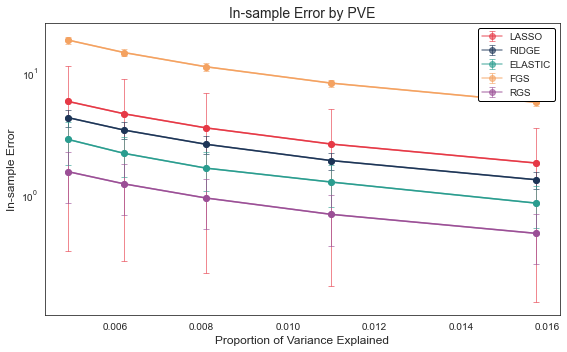

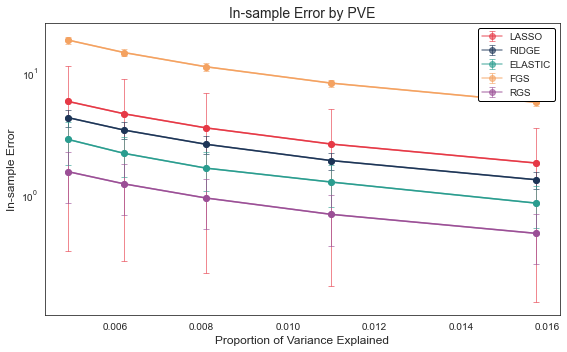

In [12]:
plot_mse_by_variance_explained("..\data\simulation_results_corr_exact_sparsity.csv", save_path="../figures/mse_by_variance_corr_exact_sparsity.png")

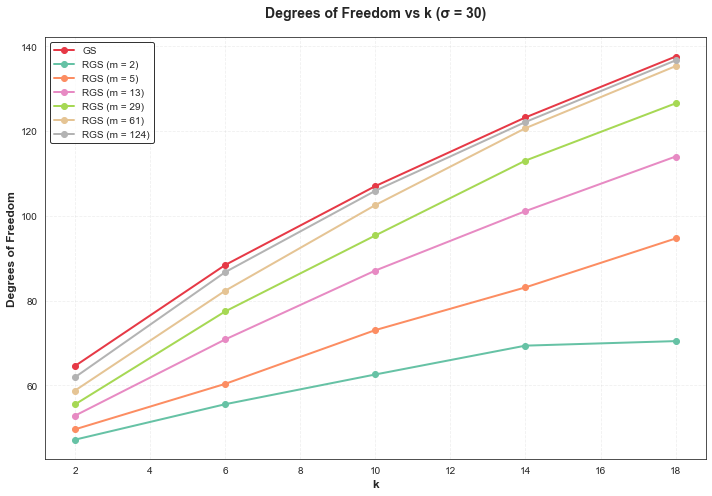

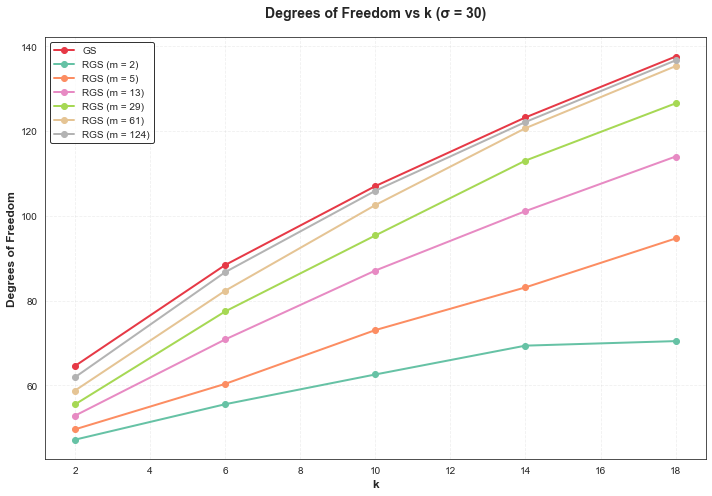

In [13]:
plot_df_vs_k("..\data\simulation_results_corr_exact_sparsity.csv", 30, save_path="../figures/df_vs_k_sigma10_corr_exact_sparsity.png")